Brain tumor classification plays a critical role in medical diagnosis and treatment planning. With the advent of ***deep learning, transfer learning*** has emerged as a powerful technique for leveraging pre-trained models on large datasets to solve new tasks with limited labeled data. In this study, we employ the **VGG16** architecture as the foundation for our brain tumor classification model. VGG16 is a well-known convolutional neural network (CNN) model that has been pre-trained on the ImageNet dataset, making it highly adept at extracting meaningful features from images. By fine-tuning the VGG16 model on a specialized brain tumor dataset, we aim to harness its exceptional ability to discern intricate patterns and discern between different tumor types. Through this research, we seek to contribute to the development of accurate and efficient brain tumor classification models that can potentially enhance diagnostic accuracy and streamline treatment decisions.

**IMPORTING NECESSARY LIBRARIES**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output

**SOME VISUALS**

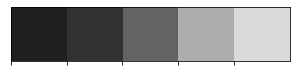

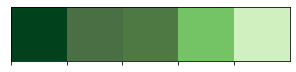

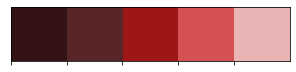

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

**DATA PREPARATION & PREPROCESSING**

In [4]:
import cv2
import os
import numpy as np
from tqdm import tqdm

image_size = 224
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

#augmentation
def flip_image(img):
    return cv2.flip(img, 1)

def flip_image_vertically(img):
    return cv2.flip(img, 0)

def rotate_image_clockwise(img):
    return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

def rotate_image_anticlockwise(img):
    return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

X_train = []
Y_train = []

for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)

        flipped_img = flip_image(img)
        flipped_img_vertically = flip_image_vertically(img)
        rotated_img_clockwise = rotate_image_clockwise(img)
        rotated_img_anticlockwise = rotate_image_anticlockwise(img)
        
        X_train.extend([flipped_img, flipped_img_vertically, rotated_img_clockwise, rotated_img_anticlockwise])
        Y_train.extend([i, i, i, i])

for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri', 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)


X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 74/74 [00:01<00:00, 71.51it/s]


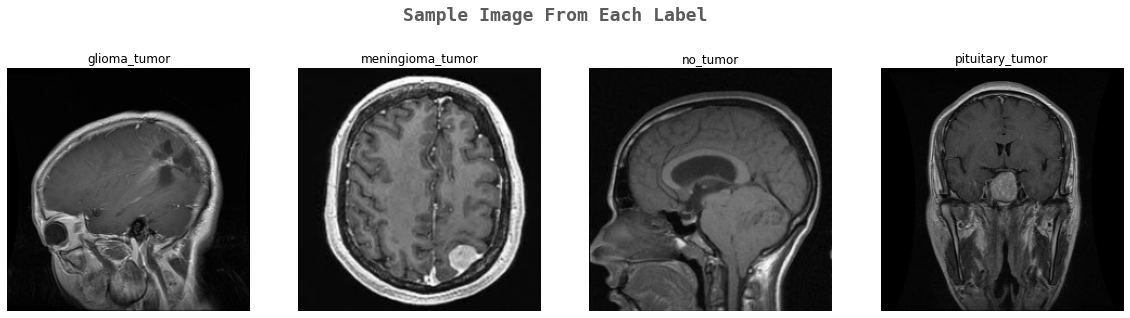

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if Y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(Y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

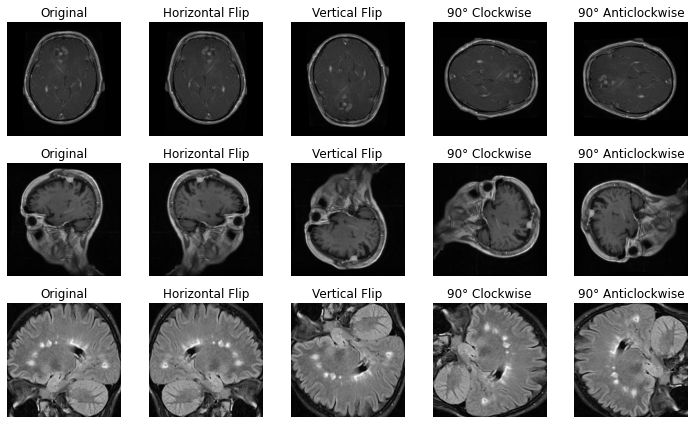

In [6]:
import matplotlib.pyplot as plt
import random

def plot_augmented_images(original_images, flipped_horizontal, flipped_vertical, rotated_clockwise, rotated_anticlockwise):
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    for i in range(3):
        axes[i, 0].imshow(original_images[i])
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(flipped_horizontal[i])
        axes[i, 1].set_title('Horizontal Flip')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(flipped_vertical[i])
        axes[i, 2].set_title('Vertical Flip')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(rotated_clockwise[i])
        axes[i, 3].set_title('90° Clockwise')
        axes[i, 3].axis('off')

        axes[i, 4].imshow(rotated_anticlockwise[i])
        axes[i, 4].set_title('90° Anticlockwise')
        axes[i, 4].axis('off')

    plt.tight_layout()
    plt.show()

random_indices = random.sample(range(len(X_train) // 5), 3)
original_images = [X_train[i * 5] for i in random_indices]
flipped_horizontal = [X_train[i * 5 + 1] for i in random_indices]
flipped_vertical = [X_train[i * 5 + 2] for i in random_indices]
rotated_clockwise = [X_train[i * 5 + 3] for i in random_indices]
rotated_anticlockwise = [X_train[i * 5 + 4] for i in random_indices]

plot_augmented_images(original_images, flipped_horizontal, flipped_vertical, rotated_clockwise, rotated_anticlockwise)


**SHUFFLING & SPLITTING THE DATA INTO TRAINING AND TESTING SETS**

In [7]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=42)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=42)

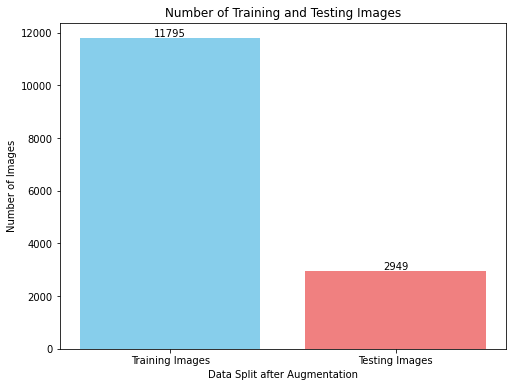

In [9]:
import numpy as np
import matplotlib.pyplot as plt

num_training_images = len(y_train)
num_testing_images = len(y_test)

plt.figure(figsize=(8, 6))

categories = ['Training Images', 'Testing Images']
counts = [num_training_images, num_testing_images]

bars = plt.bar(categories, counts, color=['skyblue', 'lightcoral'])

plt.xlabel('Data Split after Augmentation')
plt.ylabel('Number of Images')
plt.title('Number of Training and Testing Images')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')

plt.show()

**PERFORMING ONE HOT ENCODING** : 
This helps in converting labes into Numerical Values


**BELOW IS THE PSEUDOCODE FOR ANY GENERAL ONE HOT ENCODING ALOGRITHM**

    function oneHotEncode(data):
        unique_values = findUniqueValues(data)
        encoded_data = createEmptyMatrix(len(data), len(unique_values))
    
        for i = 0 to len(data) - 1:
                value = data[i]
        
       for j = 0 to len(unique_values) - 1:
                if unique_values[j] == value:
                        encoded_data[i][j] = 1
                else:
                    encoded_data[i][j] = 0
    
       return encoded_data

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**TRANSFER LEARNING**

Deep convolutional neural network models often require a significant amount of time to train, especially on large datasets. To expedite this process, a common approach is to leverage pre-trained models that have been developed and fine-tuned on standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. By reusing the weights from these pre-trained models, one can benefit from their learned representations and accelerate the training process for their own computer vision problems.

In this notebook, I will utilize the VGG16 model, which comes with pre-trained weights from the ImageNet dataset. By setting the include_top parameter to False, we exclude the top layer or output layer of the pre-built model. This allows us to add our own output layer, tailored to our specific use case.

BELOW IS THE PSEUDOCODE

***Pseudocode for generalised Transfer Learning***


pretrained_model = pretrain_model_on_source_task(source_data)


feature_extractor = remove_last_layers(pretrained_model)


target_model = build_target_model()
target_model = combine_feature_extractor_with_target_model(feature_extractor, target_model)


if fine_tuning_needed:
    for epoch in range(num_fine_tuning_epochs):
        target_model = fine_tune_model(target_model, target_data)


evaluation_metrics = evaluate_model(target_model, target_data)

predictions = target_model.predict(new_data)


***Pseudocode for Our Model***

    pretrained_model = load_pretrained_model()
    pretrained_model.last_layer = new_layer()

    for layer in pretrained_model.layers:
        layer.trainable = False

    transfer_model = create_model(pretrained_model)
    transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    new_dataset = load_new_dataset()
    preprocessed_dataset = preprocess_dataset(new_dataset)

    num_epochs = 10
    batch_size = 32

    for epoch in range(num_epochs):
        for batch in range(0, len(preprocessed_dataset), batch_size):
            batch_data = preprocessed_dataset[batch:batch+batch_size]
            transfer_model.train_on_batch(batch_data)

    test_dataset = load_test_dataset()
    preprocessed_test_dataset = preprocess_dataset(test_dataset)
    loss, accuracy = transfer_model.evaluate(preprocessed_test_dataset)

    save_model(transfer_model)


**VISUAL GEOMETRY GROUP (VGG16) BASE MODEL ARCHITECTURE**

![](https://miro.medium.com/v2/resize:fit:1400/1*NNifzsJ7tD2kAfBXt3AzEg.png)

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten

# Load VGG16 with pre-trained weights and without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# Adding our custom classification layers on top of VGG16
x = base_model.output
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)


output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

58900480/58889256 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

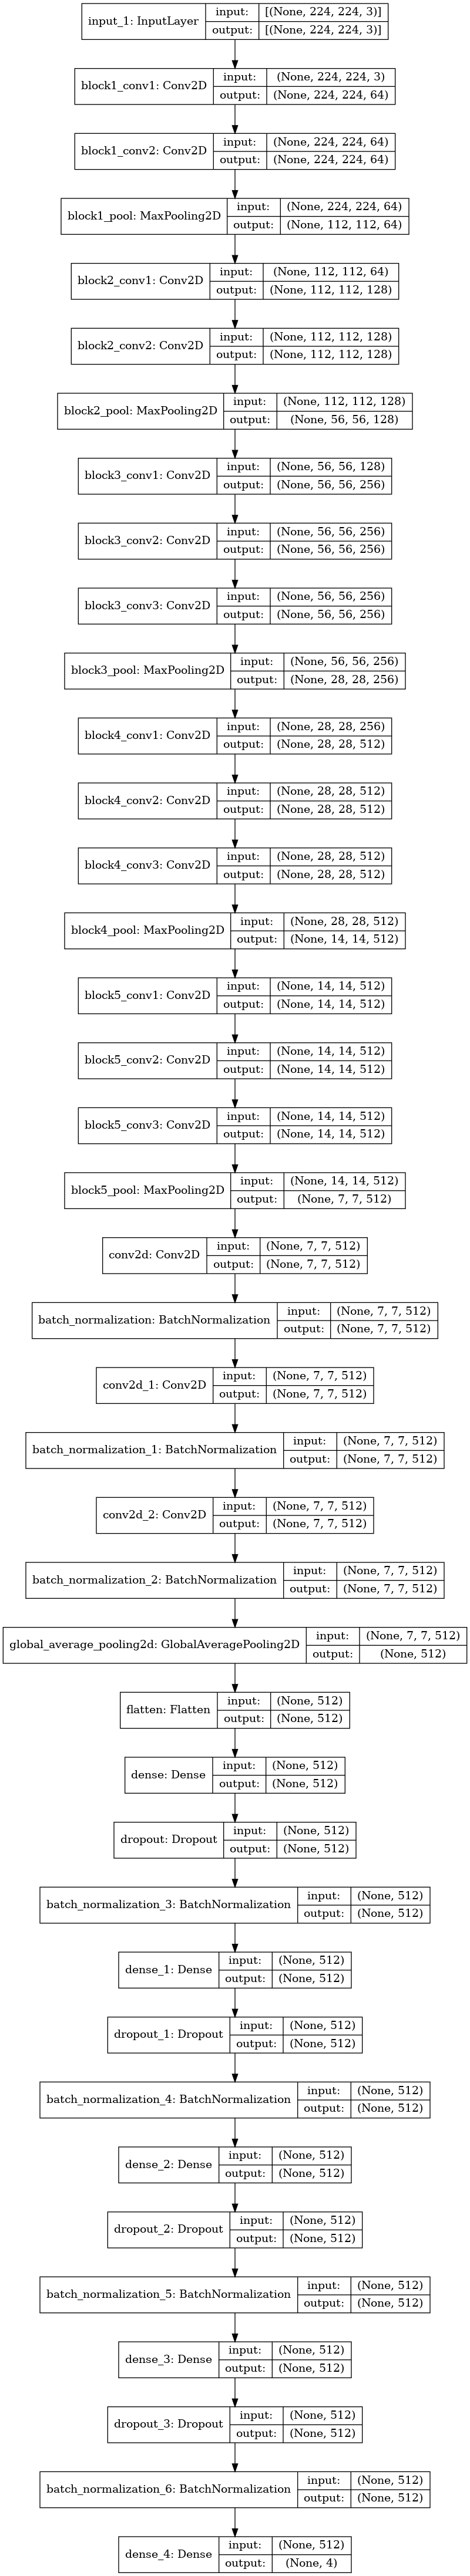

In [13]:
from tensorflow.keras.utils import plot_model


plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [14]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

***ADAM Algorithm***


![](https://www.tech-quantum.com/wp-content/uploads/2019/04/image-14.png)

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.

By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, We'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

***The ReduceLROnPlateau*** is a learning rate scheduler callback in Keras/TensorFlow that adjusts the learning rate during training based on specific conditions. It is used to control the learning rate dynamically, which can help in achieving faster convergence and better performance during training. Let's go through each parameter of the callback:

**monitor**: The metric to be monitored during training. In this case, it is set to 'val_accuracy', which means the callback will monitor the validation accuracy. When the monitored metric stops improving, the learning rate will be adjusted.

**factor**: The factor by which the learning rate will be reduced. For example, if factor=0.3, it means the learning rate will be multiplied by 0.3 (reduced to 30% of its current value) when the monitored metric stops improving.

**patience**: The number of epochs with no improvement after which the learning rate will be reduced. If the monitored metric does not improve for patience number of epochs, the learning rate will be decreased.

**min_delta**: The minimum change in the monitored metric to qualify as an improvement. For example, if min_delta=0.001, then an improvement in the monitored metric of at least 0.001 is considered as an improvement.

**mode**: Specifies whether to monitor for an increase ('max') or decrease ('min') in the monitored metric. If set to 'auto', it will automatically infer the direction based on the metric name. In this case, since the metric is validation accuracy, it will use 'max' as the mode.

**verbose**: Verbosity mode. It controls the amount of output during training. If set to 1, it will print a message when the learning rate is reduced.

In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [16]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs =15, verbose=1, batch_size=64,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
148/148 [==============================] - 46s 219ms/step - loss: 0.7562 - accuracy: 0.7263 - val_loss: 0.8801 - val_accuracy: 0.7622

Epoch 00001: val_accuracy improved from -inf to 0.76219, saving model to vgg16.h5
Epoch 2/15
148/148 [==============================] - 23s 156ms/step - loss: 0.3710 - accuracy: 0.8753 - val_loss: 0.3539 - val_accuracy: 0.8677

Epoch 00002: val_accuracy improved from 0.76219 to 0.86774, saving model to vgg16.h5
Epoch 3/15
148/148 [==============================] - 22s 149ms/step - loss: 0.2633 - accuracy: 0.9088 - val_loss: 0.2608 - val_accuracy: 0.9021

Epoch 00003: val_accuracy improved from 0.86774 to 0.90208, saving model to vgg16.h5
Epoch 4/15
148/148 [==============================] - 23s 155ms/step - loss: 0.1927 - accuracy: 0.9355 - val_loss: 0.2528 - val_accuracy: 0.9080

Epoch 00004: val_accuracy improved from 0.90208 to 0.90801, saving model to vgg16.h5
Epoch 5/15
148/148 [==============================] - 23s 156ms/step - loss: 0.

***PERFORMANCE METRICS***

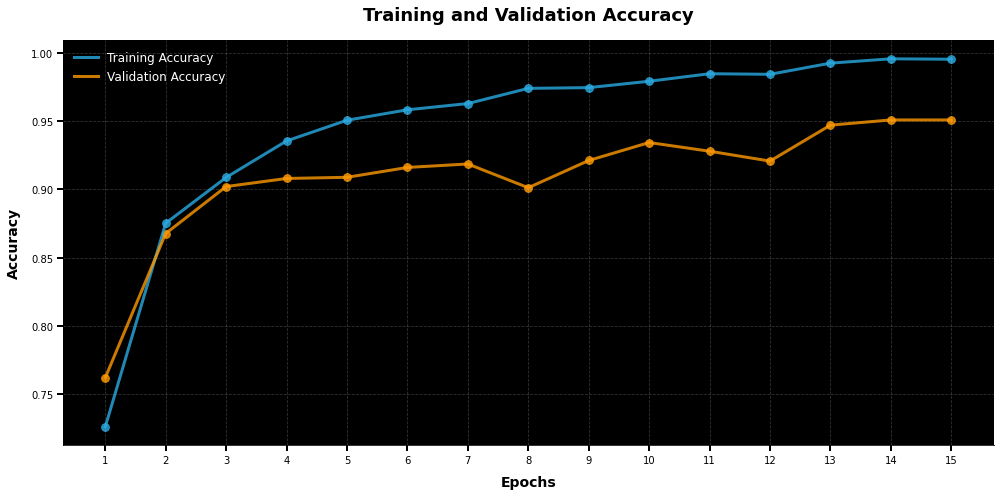

In [17]:
model.save('braintumor.h5')

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='both', length=6, width=2)
ax.set_facecolor('#000000') 

ax.plot(epochs, acc, linewidth=3, label="Training Accuracy", color='#29abe2', alpha=0.8)
ax.scatter(epochs, acc, s=60, color='#29abe2', alpha=0.8)

ax.plot(epochs, val_acc, linewidth=3, label="Validation Accuracy", color='#ff9900', alpha=0.8)
ax.scatter(epochs, val_acc, s=60, color='#ff9900', alpha=0.8)

ax.set_xlabel('Epochs', fontsize=14, labelpad=10, color='#000000', fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14, labelpad=10, color='#000000', fontweight='bold')
ax.set_title('Training and Validation Accuracy', fontsize=18, pad=20, color='#000000', fontweight='bold')

legend = ax.legend(loc='upper left', fontsize=12, frameon=False)
legend.set_title(None)
for handle in legend.legendHandles:
    handle.set_markersize(50)
legend.get_frame().set_facecolor('none')
for text in legend.get_texts():
    text.set_color('#ffffff')

ax.grid(color='#ffffff', linestyle='--', alpha=0.2)

ax.set_xticks(list(epochs))
ax.set_xticklabels(list(epochs))

plt.tight_layout()

plt.show()


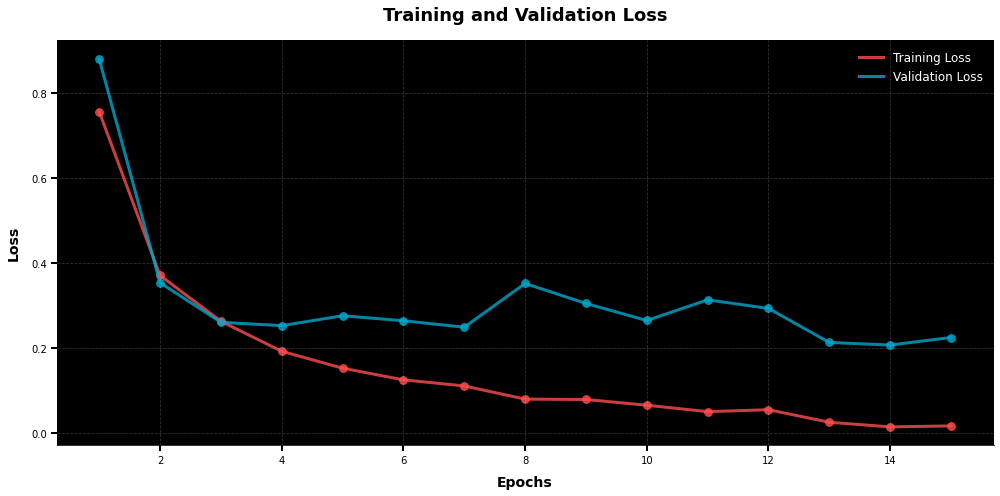

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='both', length=6, width=2)
ax.set_facecolor('#000000') 

ax.plot(epochs, loss, linewidth=3, label="Training Loss", color='#ff4e4e', alpha=0.8)
ax.scatter(epochs, loss, s=60, color='#ff4e4e', alpha=0.8)

ax.plot(epochs, val_loss, linewidth=3, label="Validation Loss", color='#00a8cc', alpha=0.8)
ax.scatter(epochs, val_loss, s=60, color='#00a8cc', alpha=0.8)

ax.set_xlabel('Epochs', fontsize=14, labelpad=10, color='#000000', fontweight='bold')
ax.set_ylabel('Loss', fontsize=14, labelpad=10, color='#000000', fontweight='bold')
ax.set_title('Training and Validation Loss', fontsize=18, pad=20, color='#000000', fontweight='bold')

legend = ax.legend(loc='upper right', fontsize=12, frameon=False)
legend.set_title(None)
for handle in legend.legendHandles:
    handle.set_markersize(50)
legend.get_frame().set_facecolor('none')
for text in legend.get_texts():
    text.set_color('#ffffff')

ax.grid(color='#ffffff', linestyle='--', alpha=0.2)

plt.tight_layout()

plt.show()


***Precision, Recall, F1-Score***

In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

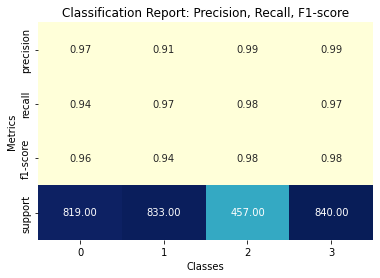

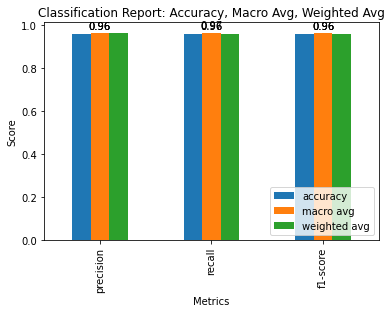

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Assuming you have already defined 'y_test_new' and 'pred' variables containing the true labels and predictions.

report = classification_report(y_test_new, pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

sns.heatmap(report_df.iloc[:-3, :].T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.title('Classification Report: Precision, Recall, F1-score')
plt.show()

metrics = ['accuracy', 'macro avg', 'weighted avg']
scores = report_df.loc[metrics, ['precision', 'recall', 'f1-score']].T
scores.plot(kind='bar', color=colors)

for i, score in enumerate(scores.values):
    for j, value in enumerate(score):
        plt.text(j, value + 0.01, '{:.2f}'.format(value), ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Classification Report: Accuracy, Macro Avg, Weighted Avg')
plt.legend(loc='lower right')

plt.subplots_adjust(hspace=0.5)

plt.show()


**F1 Score**:
The F1 score is the harmonic mean of precision and recall and is used to balance the trade-off between these two metrics. It is a single value that represents the model's overall accuracy in classifying both positive and negative instances. The formula for calculating the F1 score is as follows:
F1 = 2 * (precision * recall) / (precision + recall)

The F1 score ranges from 0 to 1, where 1 represents a perfect model that achieves both high precision and high recall.

**Precision**:
Precision, also known as positive predictive value (PPV), measures the accuracy of the positive predictions made by the model. It is the ratio of true positive predictions to the total positive predictions made by the model. The formula for precision is:
Precision = True Positives / (True Positives + False Positives)

A high precision indicates that the model has a low rate of false positives, meaning it correctly identifies positive instances without misclassifying negative instances as positive.

**Recall**:
Recall, also known as sensitivity or true positive rate (TPR), measures the ability of the model to correctly identify positive instances out of all the actual positive instances in the dataset. It is the ratio of true positive predictions to the total actual positive instances. The formula for recall is:
Recall = True Positives / (True Positives + False Negatives)

A high recall indicates that the model has a low rate of false negatives, meaning it correctly identifies a large proportion of positive instances.

In summary, precision focuses on the accuracy of positive predictions, recall focuses on the model's ability to identify positive instances, and the F1 score balances both metrics to provide a comprehensive evaluation of the model's performance.

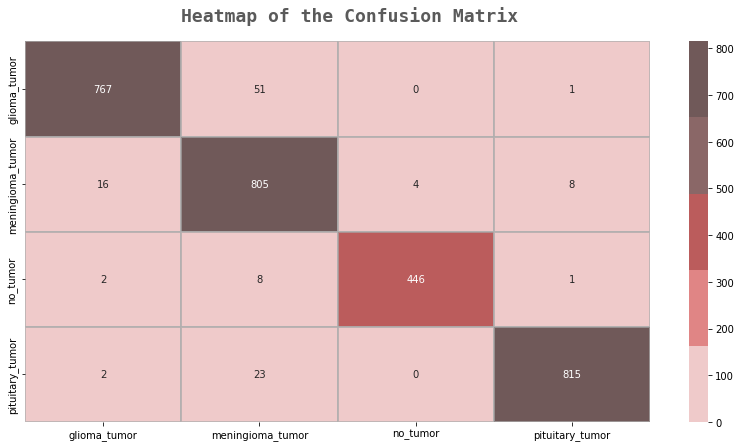

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            fmt='d', cmap=colors_red[::-1], alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()


**Prediction + Classification**

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import random


directory_path = '/kaggle/input/brain-tumor-classification-mri/Testing/'

tumor_classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

selected_files_with_labels = {tumor_class: [] for tumor_class in tumor_classes}

num_files_to_select = 3

for tumor_class in tumor_classes:
    class_directory = os.path.join(directory_path, tumor_class)
    class_files = os.listdir(class_directory)
    selected_files = random.sample(class_files, num_files_to_select)
    selected_files_with_labels[tumor_class] = [(file, tumor_class) for file in selected_files]


selected_files_with_labels = [item for sublist in selected_files_with_labels.values() for item in sublist]


image_paths = [os.path.join(directory_path, tumor_class, file) for file, tumor_class in selected_files_with_labels]
class_mapping = {
    0: 'Glioma Tumor',
    1: 'Meningioma Tumor',
    2: 'No Tumor',
    3: 'Pituitary Tumor'
}

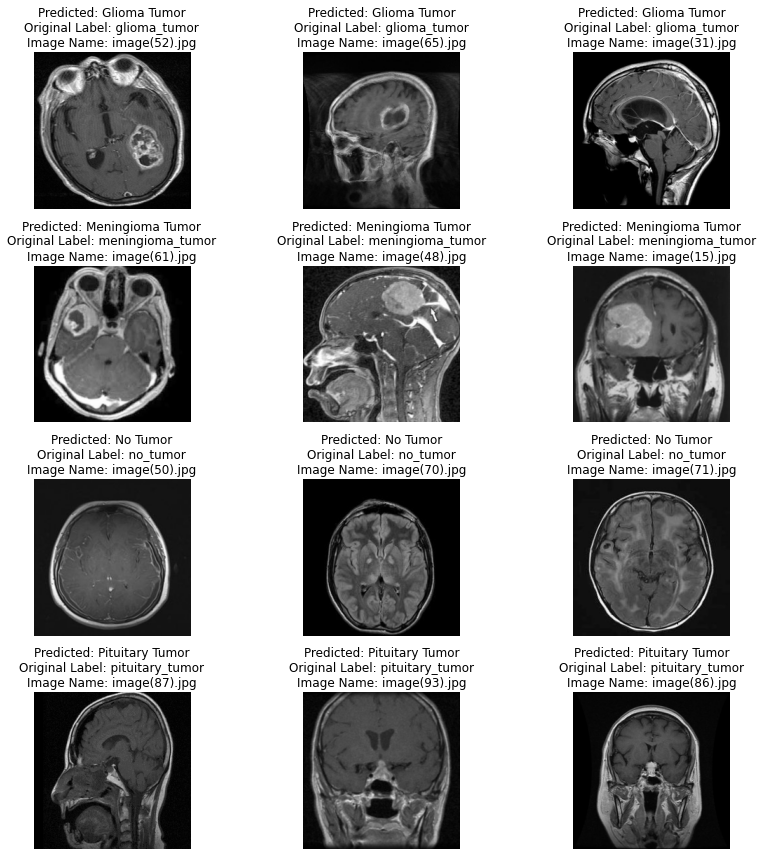

In [25]:
num_images = len(image_paths)
num_rows = int(np.ceil(np.sqrt(num_images)))
num_cols = int(np.ceil(num_images / num_rows))

def shorten_folder_name(folder_name, length=10):
    if len(folder_name) > length:
        return '...' + folder_name[-(length-3):]
    else:
        return folder_name
    
fig, axes = plt.subplots(4, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.8, wspace=0.8) 


class_counters = {class_name: 0 for class_name in class_mapping.values()}


class_images = {class_name: [] for class_name in class_mapping.values()}
class_image_indices = {class_name: [] for class_name in class_mapping.values()}

for i, (path, label) in enumerate(zip(image_paths, selected_files_with_labels)):
    img = cv2.imread(path)
    
    if img is None:
        print(f"Failed to read image: {path}")
        continue
    
    img = cv2.resize(img, (224, 224))
    
    img_array = np.array(img)
    img_array = img_array.reshape(1, 224, 224, 3)

    predictions = model.predict(img_array)
    predicted_class = class_mapping[predictions.argmax()]


    class_images[predicted_class].append(img)
    class_image_indices[predicted_class].append(i)

for i, class_name in enumerate(class_mapping.values()):
    row_images = class_images[class_name]
    row_indices = class_image_indices[class_name]
    num_images = len(row_images)

    for j in range(min(num_images, num_cols)):
        img_index = row_indices[j]  
        original_path = image_paths[img_index]  
        original_label = selected_files_with_labels[img_index][1] 
        axes[i, j].imshow(cv2.cvtColor(row_images[j], cv2.COLOR_BGR2RGB))
        axes[i, j].axis('off')
        axes[i, j].set_title(f"Predicted: {class_name}\nOriginal Label: {original_label}\nImage Name: {os.path.basename(original_path)}")  # Use '\n' for a new line


    for j in range(num_images, num_cols):
        fig.delaxes(axes[i, j])


    class_counters[class_name] += num_cols

plt.tight_layout()
plt.show()